# Set up

## Package Loading

In [21]:
import pandas as pd
import numpy as np
import itertools
!pip install emoji
import emoji
import re
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer 
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
! pip install imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import mlxtend
import matplotlib.pyplot as plt
import time
import joblib
import gzip
import json
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set Up paths

In [22]:
# Parent paths
parent_path = '/content/drive/My Drive/'


#Specific paths
path_hyperparameters_nb = parent_path+"Web_Mining_Project/more_features/classifier_parameters/best_parameters/nb.csv"
path_hyperparameters_knn = parent_path+"Web_Mining_Project/more_features/classifier_parameters/best_parameters/knn.csv"
path_hyperparameters_rf = parent_path+"Web_Mining_Project/more_features/classifier_parameters/best_parameters/rf.csv"
path_hyperparameters_svm = parent_path+"Web_Mining_Project/more_features/classifier_parameters/best_parameters/svm.csv"
path_hyperparameters_lr = parent_path+"Web_Mining_Project/more_features/classifier_parameters/best_parameters/lr.csv"

path_best_parameters_nb = parent_path+"Web_Mining_Project/more_features/classifier_parameters/nb.pkl"
path_best_parameters_knn = parent_path+"Web_Mining_Project/more_features/classifier_parameters/knn.pkl"
path_best_parameters_rf = parent_path+"Web_Mining_Project/more_features/classifier_parameters/rf.pkl"
path_best_parameters_svm = parent_path+"Web_Mining_Project/more_features/classifier_parameters/svm.pkl"
path_best_parameters_lr = parent_path+"Web_Mining_Project/more_features/classifier_parameters/lr.pkl"
#dataset paths 
path_complete_dataset = parent_path + "Web_Mining_Project/data/complete_dataset.csv"
path_shortend_dataset = parent_path + "Web_Mining_Project/data/shortend10000_dataset.csv"
path_shortend10000_preprocessed = parent_path + "Web_Mining_Project/data/shortend10000_dataset_preprocessed.csv"
path_shortend50000_preprocessed = parent_path + "Web_Mining_Project/data/shortend50000_dataset_preprocessed.csv"

## Set Up Functions

In [23]:
# function for evaluation(confusion matrix)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# function for sentiment label creating 
def create_labels_from_rating(score):
  score = int(score)
  if score <= 2:
    return 0 #negative
  elif score == 3:
    return 1 #neutral
  else:
    return 2 #positive
  
# function to bin vote column 
def bin_vote(vote):
  vote = int(vote)

  if vote < 2:
    return 0
  elif vote >= 2 and vote <= 6:
    return 1 
  else:
    return 2

# Data Download and Exploration

In [24]:
# create dataframe 
df = pd.read_csv(path_shortend_dataset)
df.drop(columns=['Unnamed: 0'], inplace=True)
print(df.shape)
df.head()

(10000, 12)


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4.0,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3.0,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2.0,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5.0,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


overall           False
verified          False
reviewTime        False
reviewerID        False
asin              False
reviewerName      False
reviewText        False
summary            True
unixReviewTime    False
vote               True
style              True
image              True
dtype: bool

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         10000 non-null  float64
 1   verified        10000 non-null  bool   
 2   reviewTime      10000 non-null  object 
 3   reviewerID      10000 non-null  object 
 4   asin            10000 non-null  object 
 5   reviewerName    10000 non-null  object 
 6   reviewText      10000 non-null  object 
 7   summary         9999 non-null   object 
 8   unixReviewTime  10000 non-null  int64  
 9   vote            2716 non-null   float64
 10  style           3784 non-null   object 
 11  i

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


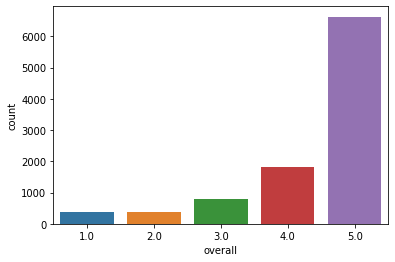

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning



count    10000.000000
mean         1.743100
std          7.031931
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        281.000000
Name: vote, dtype: float64


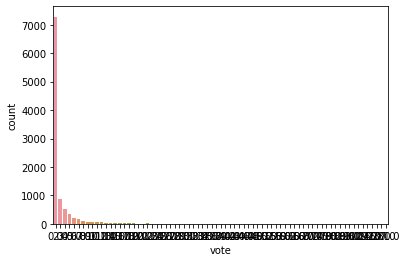

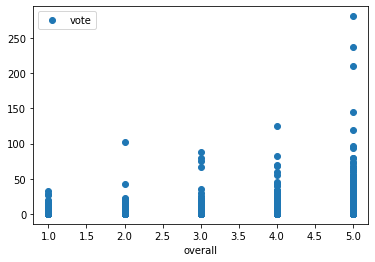

In [25]:
# General Information and Null values
print(df.isnull().any())
print()
df.info()
print()
print(df.dtypes)
print()
print(df.overall.describe())
print()
# plot the score & check for the distribution of the star ratings 
sns.countplot(df.overall)
plt.show()
print()
# plot distribution of vote column
df['vote'] = df['vote'].fillna(0)
sns.countplot(df.vote)
print()
print(df.vote.describe())
# plot vote depending on overall
df.plot(x='overall', y='vote', style='o')

# Data Preprocessing and further Exploration

## Label creation

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


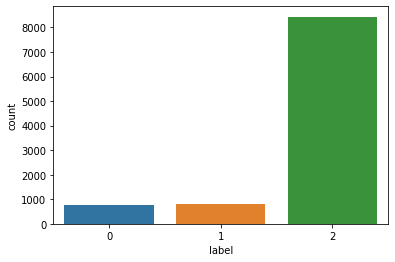

In [26]:
df['label'] = df['overall'].apply(create_labels_from_rating)
# plot the score & check for the distribution of the star ratings 
sns.countplot(df.label)
plt.show()

## Feature Generation and Selection

In [27]:
df.sort_values(by=['unixReviewTime'], inplace=True)
df.reset_index(drop=True, inplace=True)

# detecting ratings score per user
df['reviewer_mean_score'] = df.groupby(['reviewerID'])['overall'].apply(lambda x: x.expanding(1).mean().shift()).reset_index(0,drop=True)
df['reviewer_min_score'] = df.groupby(['reviewerID'])['overall'].apply(lambda x: x.expanding(1).min().shift()).reset_index(0,drop=True)
df['reviewer_max_score'] = df.groupby(['reviewerID'])['overall'].apply(lambda x: x.expanding(1).max().shift()).reset_index(0,drop=True)

# detecting ratings score per item
df['item_mean_score'] = df.groupby(['asin'])['overall'].apply(lambda x: x.expanding(1).mean().shift()).reset_index(0,drop=True)
df['item_min_score'] = df.groupby(['asin'])['overall'].apply(lambda x: x.expanding(1).min().shift()).reset_index(0,drop=True)
df['item_max_score'] = df.groupby(['asin'])['overall'].apply(lambda x: x.expanding(1).max().shift()).reset_index(0,drop=True)
df.drop(columns=['overall','reviewerName','reviewerID', 'asin', 'reviewTime','style', 'image'], inplace=True)

# delete nans 
#df['reviewer_mean_score'] = df['reviewer_mean_score'].fillna(3)
#df['reviewer_min_score'] = df['reviewer_min_score'].fillna(3)
#df['reviewer_max_score'] = df['reviewer_max_score'].fillna(3)
#df['item_mean_score'] = df['item_mean_score'].fillna(3)
#df['item_min_score'] = df['item_min_score'].fillna(3)
#df['item_max_score'] = df['item_max_score'].fillna(3)

In [28]:
df = df[df['reviewText'].apply(lambda x: isinstance(x, str))] 
df = df[df['summary'].apply(lambda x: isinstance(x, str))]
df.dropna(inplace=True)
print(df.shape)
print(df.head())

(4759, 12)
    verified                                         reviewText  \
17     False  This is without any doubt the best sci-fi RPG ...   
19     False  If you liked Full Trottle and love LucasArts' ...   
25     False  The first Age of Empires was great. The second...   
31     False  This is quite simply the best action titles I ...   
33     False  This game's great!  Some people are complainin...   

                         summary  unixReviewTime  vote  label  \
17     The best sci-fi RPG ever!       943488000   7.0      2   
19  LucasArts have done it again       943488000   8.0      2   
25              Computer crasher       943747200  43.0      0   
31                Buy it Dammit!       944179200   3.0      2   
33  You Want RPG; You've Got RPG       944352000   3.0      2   

    reviewer_mean_score  reviewer_min_score  reviewer_max_score  \
17             4.000000                 4.0                 4.0   
19             4.666667                 4.0                 5

## Tokenization 

In [29]:
df = df[df['reviewText'].apply(lambda x: isinstance(x, str))] 
df = df[df['summary'].apply(lambda x: isinstance(x, str))]

#tokenize and use stemming 
#stemmer = PorterStemmer()
#print(df.head())
#df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
#df['summary'] = df['summary'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
#print(df.head())

# tokenize and remove stopwords 
stop = stopwords.words('english')
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['summary'] = df['summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.dropna(inplace=True)
print(df.head())
print(df.shape)

    verified                                         reviewText  \
17     False  This without doubt best sci-fi RPG ever (and I...   
19     False  If liked Full Trottle love LucasArts' games ge...   
25     False  The first Age Empires great. The second one pl...   
31     False  This quite simply best action titles I ever pl...   
33     False  This game's great! Some people complaining ori...   

                         summary  unixReviewTime  vote  label  \
17     The best sci-fi RPG ever!       943488000   7.0      2   
19                LucasArts done       943488000   8.0      2   
25              Computer crasher       943747200  43.0      0   
31                   Buy Dammit!       944179200   3.0      2   
33  You Want RPG; You've Got RPG       944352000   3.0      2   

    reviewer_mean_score  reviewer_min_score  reviewer_max_score  \
17             4.000000                 4.0                 4.0   
19             4.666667                 4.0                 5.0   
25   

# Train Test Split and shortening 

In [30]:
df.dropna(inplace=True)
df = df[df['reviewText'].apply(lambda x: isinstance(x, str))] 
df = df[df['summary'].apply(lambda x: isinstance(x, str))]

In [31]:
# split into train and test set
x_train, x_test = train_test_split(df, test_size=0.2, random_state = 453, stratify=df['label'])

y_train = x_train['label']
y_test = x_test['label']

print (f"y_train: {y_train.shape}/ x_train: {x_train.shape}")
print (f"y_test: {y_test.shape}/ x_test: {x_test.shape}")

print(x_train.head())

y_train: (3807,)/ x_train: (3807, 12)
y_test: (952,)/ x_test: (952, 12)
      verified                                         reviewText  \
3011     False  I really looking forward trying game I pretty ...   
3180     False  The first X-Men game classic I also say Clone ...   
558      False  Hey, I remember old gold-laden boxes first AD&...   
6771      True  It great re-living childhood days playing game...   
9616     False  Better second good first. My brother got birth...   

                                        summary  unixReviewTime  vote  label  \
3011                    Frustrating & Confusing      1064188800   2.0      1   
3180  A bit cartoony really awesome video game!      1078012800   0.0      2   
558                           AD&D rises ashes!       966211200   0.0      2   
6771                                     Great!      1382745600   0.0      2   
9616                      Still good first game      1473465600   0.0      1   

      reviewer_mean_score  revie

# Model Training

## Set Up Pipeline

In [32]:

# define transformer
transformer = ColumnTransformer(transformers=[('tf_reviewText', TfidfVectorizer(max_df=0.75, smooth_idf=False, norm='l2'), 'reviewText'), ('tf_summary', TfidfVectorizer(max_df=0.75, smooth_idf=False, norm='l2'), 'summary')], remainder='passthrough')

# define sampling
sampling = RandomOverSampler(random_state=452)

# define the scoring function
f1 = make_scorer(f1_score, average='weighted')

# set up cross validation configuration
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# dataset preparation
x_train.drop(columns = ['label'], inplace= True)
x_test.drop(columns = ['label'], inplace= True)
#x_train = x_train['reviewText']
#x_test = x_valid['reviewText']
print(x_train.shape)
print(y_train.shape)
print(x_train.head(5))




(3807, 11)
(3807,)
      verified                                         reviewText  \
3011     False  I really looking forward trying game I pretty ...   
3180     False  The first X-Men game classic I also say Clone ...   
558      False  Hey, I remember old gold-laden boxes first AD&...   
6771      True  It great re-living childhood days playing game...   
9616     False  Better second good first. My brother got birth...   

                                        summary  unixReviewTime  vote  \
3011                    Frustrating & Confusing      1064188800   2.0   
3180  A bit cartoony really awesome video game!      1078012800   0.0   
558                           AD&D rises ashes!       966211200   0.0   
6771                                     Great!      1382745600   0.0   
9616                      Still good first game      1473465600   0.0   

      reviewer_mean_score  reviewer_min_score  reviewer_max_score  \
3011                 4.25                 4.0             

## Naïve Bayes

In [13]:

# Optimize parameters for NB Classifier
from sklearn.naive_bayes import MultinomialNB
estimator = MultinomialNB()

# Define grid of possible hyperparamters values 
parameters = {
    #'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],  ------- used vectorizer parameters from only text runs with classifiers
    #'vectorizer__smooth_idf': (True, False),
    #'vectorizer__norm': ('l1', 'l2', None),
    'estimator__alpha': [ 0.0001, 0.001, 0.01, 0.1, 1, 10],
}

# Create a pipeline
pipeline = Pipeline([ ('FeaturePreprocessing', transformer),('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=10)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Multinomial NBClassifier: {}% F1-score for class 'label' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_nb, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_nb, compress = 1) # Only best parameters


Pipeline(steps=[('FeaturePreprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tf_reviewText',
                                                  TfidfVectorizer(max_df=0.75,
                                                                  smooth_idf=False),
                                                  'reviewText'),
                                                 ('tf_summary',
                                                  TfidfVectorizer(max_df=0.75,
                                                                  smooth_idf=False),
                                                  'summary')])),
                ('balancing', RandomOverSampler(random_state=452)),
                ('estimator', MultinomialNB())])
Fitting 5 folds for each of 6 candidates, totalling 30 fits
--- 24.93198871612549 seconds ---
Multinomial NBClassifier: 80.97020485693494% F1-score for class 'label' with parameters {'estimator

['/content/drive/My Drive/Web_Mining_Project/more_features/classifier_parameters/nb.pkl']

              precision    recall  f1-score   support

           0       0.43      0.32      0.37        65
           1       0.36      0.35      0.36        85
           2       0.91      0.93      0.92       802

    accuracy                           0.83       952
   macro avg       0.56      0.53      0.55       952
weighted avg       0.83      0.83      0.83       952



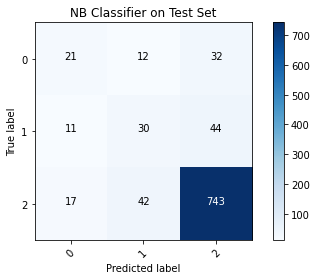

In [14]:
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "NB Classifier on Test Set")
print(classification_report(y_test, prediction))

## Knn

In [15]:
# Optimize parameters for KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
estimator = KNeighborsClassifier()

transformer = ColumnTransformer(transformers=[('tf_reviewText', TfidfVectorizer(max_df=0.75, smooth_idf=False, norm=None), 'reviewText'), ('tf_summary', TfidfVectorizer(max_df=0.75, smooth_idf=False, norm=None), 'summary')], remainder='passthrough')

# Define grid of posible hyperparamters values 
parameters = {
    #'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    #'vectorizer__smooth_idf': (True, False),
    #'vectorizer__norm': ('l1', 'l2', None),
    'estimator__n_neighbors': [5, 10, 15, 20, 25],
    'estimator__weights': ['uniform','distance'],
    'estimator__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
       }

# Create a pipeline
pipeline = Pipeline([ ('FeaturePreprocessing', transformer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=10)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("KNN : {}% F1-score for class 'label' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_knn, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_knn, compress = 1) # Only best parameters

Pipeline(steps=[('FeaturePreprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tf_reviewText',
                                                  TfidfVectorizer(max_df=0.75,
                                                                  norm=None,
                                                                  smooth_idf=False),
                                                  'reviewText'),
                                                 ('tf_summary',
                                                  TfidfVectorizer(max_df=0.75,
                                                                  norm=None,
                                                                  smooth_idf=False),
                                                  'summary')])),
                ('balancing', RandomOverSampler(random_state=452)),
                ('estimator', KNeighborsClassifier())])
Fitting 5 folds for each of 40 c

['/content/drive/My Drive/Web_Mining_Project/more_features/classifier_parameters/knn.pkl']

              precision    recall  f1-score   support

           0       0.17      0.26      0.20        65
           1       0.12      0.21      0.16        85
           2       0.86      0.76      0.81       802

    accuracy                           0.67       952
   macro avg       0.38      0.41      0.39       952
weighted avg       0.75      0.67      0.71       952



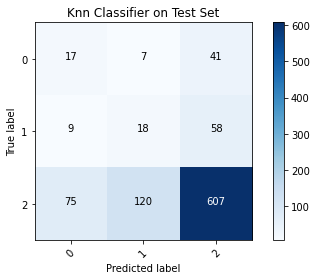

In [16]:
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "Knn Classifier on Test Set")
print(classification_report(y_test, prediction))

## Random Forest

In [17]:
# Optimize parameters for Random Forest
estimator = RandomForestClassifier( random_state=42)

transformer = ColumnTransformer(transformers=[('tf_reviewText', TfidfVectorizer(max_df=0.25, smooth_idf=False), 'reviewText'), ('tf_summary', TfidfVectorizer(max_df=0.25, smooth_idf=False), 'summary')], remainder='passthrough')

# Define grid of posible hyperparamters values 
parameters = {
    #'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    #'vectorizer__smooth_idf': (True, False),
    #'vectorizer__norm': ('l1', 'l2', None),
    'estimator__n_estimators': [100, 300, 500],
    'estimator__max_depth': [5, 15, 25],
    'estimator__min_samples_split': [5, 25, 100],
    'estimator__min_samples_leaf': [ 2, 5, 10]
}

# Create a pipeline
pipeline = Pipeline([ ('FeaturePreprocessing', transformer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=10)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Random Forest Classifier: {}% F1-score for class 'label' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_rf, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_rf, compress = 1) # Only best parameters

Pipeline(steps=[('FeaturePreprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tf_reviewText',
                                                  TfidfVectorizer(max_df=0.25,
                                                                  smooth_idf=False),
                                                  'reviewText'),
                                                 ('tf_summary',
                                                  TfidfVectorizer(max_df=0.25,
                                                                  smooth_idf=False),
                                                  'summary')])),
                ('balancing', RandomOverSampler(random_state=452)),
                ('estimator', RandomForestClassifier(random_state=42))])
Fitting 5 folds for each of 81 candidates, totalling 405 fits
--- 906.0206696987152 seconds ---
Random Forest Classifier: 82.65812492299057% F1-score for class 'label' w

['/content/drive/My Drive/Web_Mining_Project/more_features/classifier_parameters/rf.pkl']

              precision    recall  f1-score   support

           0       0.47      0.40      0.43        65
           1       0.38      0.29      0.33        85
           2       0.91      0.94      0.92       802

    accuracy                           0.85       952
   macro avg       0.59      0.54      0.56       952
weighted avg       0.83      0.85      0.84       952



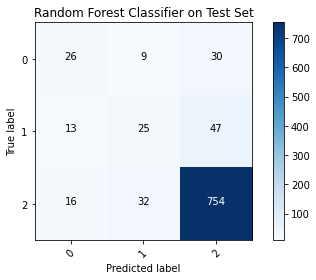

In [18]:
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "Random Forest Classifier on Test Set")
print(classification_report(y_test, prediction))

## SVM



In [19]:
# Optimize parameters for LSVM Classifier
estimator = LinearSVC(max_iter=5000, random_state=42, dual = True)

transformer = ColumnTransformer(transformers=[('tf_reviewText', TfidfVectorizer(), 'reviewText'), ('tf_summary', TfidfVectorizer(), 'summary')], remainder='passthrough')

# Define grid of posible hyperparamters values 
parameters = {
    #'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    #'vectorizer__smooth_idf': (True, False),
    #'vectorizer__norm': ('l1', 'l2', None),
    'estimator__loss': ['hinge', 'squared_hinge'],
    'estimator__tol': [1e-2, 1e-3, 1e-4, 1e-5],
    'estimator__C': [0.01, 0.1, 1, 10, 100, 1000],
}

# Create a pipeline
pipeline = Pipeline([ ('FeaturePreprocessing', transformer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("LSVM Classifier: {}% F1-score for class 'label' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_svm, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_svm, compress = 1) # Only best parameters

Pipeline(steps=[('FeaturePreprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tf_reviewText',
                                                  TfidfVectorizer(),
                                                  'reviewText'),
                                                 ('tf_summary',
                                                  TfidfVectorizer(),
                                                  'summary')])),
                ('balancing', RandomOverSampler(random_state=452)),
                ('estimator', LinearSVC(max_iter=5000, random_state=42))])
Fitting 5 folds for each of 48 candidates, totalling 240 fits
--- 10153.255246162415 seconds ---
LSVM Classifier: 16.300221914200197% F1-score for class 'label' with parameters {'estimator__C': 0.01, 'estimator__loss': 'hinge', 'estimator__tol': 0.01}


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


['/content/drive/My Drive/Web_Mining_Project/more_features/classifier_parameters/svm.pkl']

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.00      0.00      0.00        85
           2       0.84      1.00      0.91       802

    accuracy                           0.84       952
   macro avg       0.28      0.33      0.30       952
weighted avg       0.71      0.84      0.77       952



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


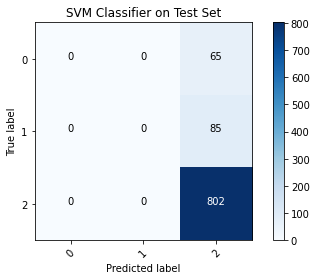

In [20]:
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "SVM Classifier on Test Set")
print(classification_report(y_test, prediction))

## Logistic Regression

In [34]:
# Optimize parameters for Logistic Regression
estimator = LogisticRegression()

transformer = ColumnTransformer(transformers=[('tf_reviewText', TfidfVectorizer(max_df=0.5, smooth_idf=False), 'reviewText'), ('tf_summary', TfidfVectorizer(max_df=0.5, smooth_idf=False), 'summary')], remainder='passthrough')

# Define grid of posible hyperparamters values 
parameters = {
    #'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    #'vectorizer__smooth_idf': (True, False),
    #'vectorizer__norm': ('l1', 'l2', None),
    'estimator__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'estimator__C': [100, 10, 1.0, 0.1, 0.01]
}

# Create a pipeline
pipeline = Pipeline([ ('FeaturePreprocessing', transformer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Logistic Regression Classifier: {}% F1-score for class 'label' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_lr, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_lr, compress = 1) # Only best parameters

Pipeline(steps=[('FeaturePreprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tf_reviewText',
                                                  TfidfVectorizer(max_df=0.5,
                                                                  smooth_idf=False),
                                                  'reviewText'),
                                                 ('tf_summary',
                                                  TfidfVectorizer(max_df=0.5,
                                                                  smooth_idf=False),
                                                  'summary')])),
                ('balancing', RandomOverSampler(random_state=452)),
                ('estimator', LogisticRegression())])
Fitting 5 folds for each of 25 candidates, totalling 125 fits
--- 199.35793805122375 seconds ---
Logistic Regression Classifier: 77.07065007791553% F1-score for class 'label' with parameters

['/content/drive/My Drive/Web_Mining_Project/more_features/classifier_parameters/lr.pkl']

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.00      0.00      0.00        85
           2       0.84      1.00      0.91       802

    accuracy                           0.84       952
   macro avg       0.28      0.33      0.30       952
weighted avg       0.71      0.84      0.77       952



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


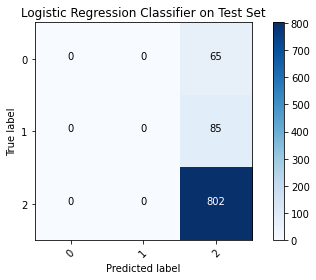

In [35]:
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "Logistic Regression Classifier on Test Set")
print(classification_report(y_test, prediction))